# Perform Fisher forecast for LSST-Y1 data constraint on cosmological parameters

In this notebook we use [```jax-cosmo```](https://github.com/DifferentiableUniverseInitiative/jax_cosmo) to perform a Fisher forecast for the constraint on cosmological parameters from an LSST-Y1 like survey.

## Load the python modules

In [1]:
## os library for computer path
import os.path

## numpy library
import numpy as np

## jax library for autodiff
import jax
## enable x64
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
## jax-cosmo library - main driver for producing observables and fisher forecasts
import jax_cosmo as jc
## CCL library - DES official library, serves a cross-check of the Fisher matrix stability in jax-cosmo
import pyccl as ccl

## astropy module to handle fits file
from astropy.io import fits

## matplotlib library
import matplotlib
from matplotlib.ticker import MultipleLocator, FormatStrFormatter # for tick format
from matplotlib import cm # for colormaps
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
## personal preference for matplotlib fonts
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "sans-serif",
    #"font.sans-serif": "Computer Modern",
    "font.size": 22})

## Generate the redshift distributions

### Generate source and lens n(z)

We follow Frusciante, et. al. ([arXiv:2306.12368](https://arxiv.org/abs/2306.12368)) in using a Smail redshift distribution for galaxies
$$n(z)\propto z^2\mathrm{exp}[-(z/z_0)^\alpha],$$
divided into 10 tomographic bins. For both the lens and source galaxies, we take $(\alpha,z_0) = (3/2, 0.9/\sqrt{2})$ and $n_\mathrm{eff} = 30\text{ arcmin}^{-2}.$ We then divide each distribution into 10 tomographic bins.

In [2]:
#Source and lens n(z) are identical for now.
n_source_eff = 30
nz_s = jc.redshift.smail_nz(2, 1.5, .9*2**-.5, n_gals_per_arcmin2 = 30, zmax=2.5)
#nz_s = jc.redshift.smail_nz(2,2,2, n_gals_per_armin2=n_source_eff)
n_lens_eff = 30
nz_l = jc.redshift.smail_nz(2, .94, .26, n_gals_per_arcmin2=n_lens_eff)
#nz_l = jc.redshift.smail_nz(2,2,2, n_gals_per_armin2=n_lens_eff)
zbin_edges_s = np.array([.001, .42, .56, .68, .79, .9, 1.02, 1.15, 1.32, 1.58, 2.5])
zbin_edges_l = np.array([0, .4509, .6778, .9293, 1.2936, 10])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
zbin_centers_s=0.5*(zbin_edges_s[:-1] + zbin_edges_s[1:])
zbin_widths_s=zbin_edges_s[1:]-zbin_edges_s[:-1]
zbin_transitions_s=np.ones_like(zbin_centers_s)*0.05
zbin_smooth_sigmas_s=np.ones_like(zbin_centers_s)*0.05
print(zbin_centers_s)
print(zbin_widths_s)

[0.2105 0.49   0.62   0.735  0.845  0.96   1.085  1.235  1.45   2.04  ]
[0.419 0.14  0.12  0.11  0.11  0.12  0.13  0.17  0.26  0.92 ]


In [4]:
nzs_s = [jc.redshift.gaussian_sigmoid_nz(nz_s,
                        zbin_centers_s[i], zbin_widths_s[i], zbin_transitions_s[i],
                        0.0, bw=zbin_smooth_sigmas_s[i], gals_per_arcmin2=nz_s.gals_per_arcmin2/len(zbin_centers_s))
                        # bw=zbin_smooth_sigmas[i])
        for i in range(zbin_centers_s.shape[0])]

zbin_centers_l = zbin_centers_s
nzs_l = nzs_s

In [5]:
#nz_convolved = jc.redshift.gaussian_convolution(nzs_s[0], 0, 0.05)
#print(nz_convolved(.5))

In [6]:
#n_source_bin1 = jc.redshift.gaussian_convolution(jc.redshift.step_fcn(n_source_total, 0, .36), 0, .05)
#n_source_bin1 = jc.redshift.step_fcn(n_source_total, 0, .36)
#print(n_source_bin1.gals_per_arcmin2)
#print(n_source_bin1(.3))
#print(n_source_total(.3))

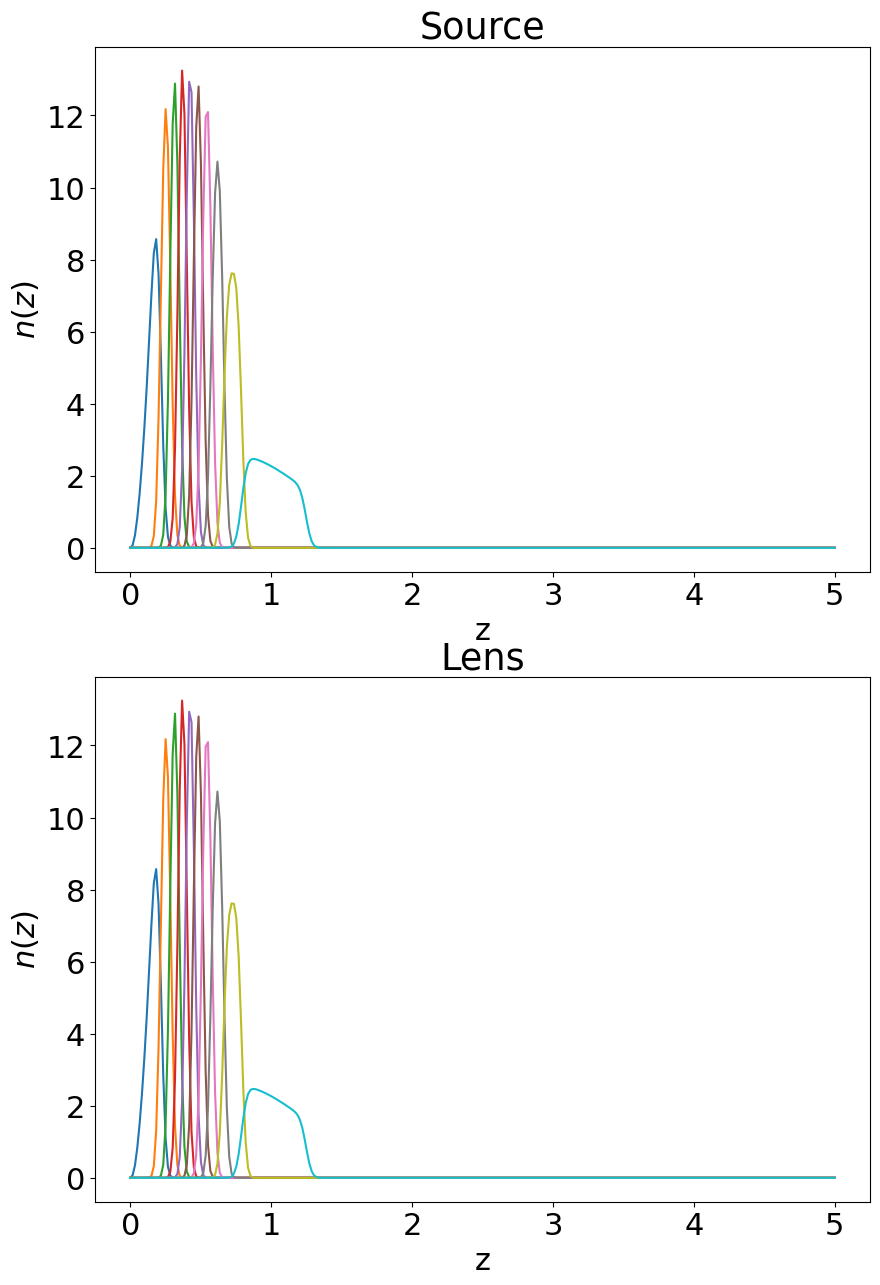

In [7]:
z = np.linspace(0,5, 300)
fig, ax = plt.subplots(2,1, figsize=(10,15))
for i in range(10):
    ax[0].plot(z, nzs_s[i](z), label='Bin '+str(i+1))
    ax[1].plot(z, nzs_l[i](z), label='Bin '+str(i+1))
    ax[0].set_title('Source')
    ax[1].set_title('Lens')
    ax[0].set_ylabel(r'$n(z)$')
    ax[1].set_ylabel(r'$n(z)$')
    ax[0].set_xlabel(r'z')
    ax[1].set_xlabel(r'z')
#ax[0].plot(z, n_source_total(z))

In [8]:
#print(jc.scipy.integrate.romb(n_source_total, 0, .4509))

## Define utility functions that are not yet supported by jax-cosmo but useful for DES analyses 

### Specify standard input parameter(s)

In [9]:
## The number of cosmological parameters in the parameter vector, i.e. the number of cosmo parameters we vary
cosmo_param_nr=9

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from jax.scipy.linalg import eigh, inv
from jax.scipy.stats import norm

def plot_contours(fisher, pos, inds, cls=np.array([0.6827, 0.9545]), ax=None, **kwargs):
    """
    Plot 2D parameter contours given a Hessian matrix of the likelihood
    Parameters:
    -----------
    fisher : (M, M) array_like
        Input Fisher matrix.
    pos : (M,) array_like
        Fiducial parameter values.
    inds : (2,) array_like
        Parameter indices.
    cl1, cl2 : float
        Confidence levels of ellipse contours.
    """
    
    def eigsorted(cov):
        vals, vecs = eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    def sigma_marg(cov, i):
        return np.sqrt(cov[i, i])

    # Argument validation
    assert fisher.shape[0] == fisher.shape[1], "Fisher matrix must be square"
    assert len(pos) == fisher.shape[0], "Position vector dimension must match Fisher matrix"
    assert len(inds) == 2, "Indices must specify a 2D slice of the Fisher matrix"

    cov = inv(fisher)
    cov = cov[inds][:, inds]
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    cls = .5*(1+cls)
    nstds = norm.ppf(cls)
    #nstd1 = norm.ppf(0.5 * (1 + cl1))
    #nstd2 = norm.ppf(0.5 * (1 + cl2))

    ellips = []
    for nstd in nstds:
       ellip = Ellipse(xy=pos[inds], width=2.0 * nstd * np.sqrt(vals[0]),
                     height=2.0 * nstd * np.sqrt(vals[1]), angle=theta, **kwargs)
       ellips.append(ellip)
    '''ellip1 = Ellipse(xy=pos[inds], width=2.0 * nstd1 * np.sqrt(vals[0]),
                     height=2.0 * nstd1 * np.sqrt(vals[1]), angle=theta, **kwargs)
    ellip2 = Ellipse(xy=pos[inds], width=2.0 * nstd2 * np.sqrt(vals[0]),
                     height=2.0 * nstd2 * np.sqrt(vals[1]), angle=theta, **kwargs)'''

    if ax is None:
        ax = plt.gca()

    for ellip in ellips:
       ax.add_artist(ellip)

    nstdmax = max(nstds)
    sx = nstdmax * sigma_marg(cov, 0)
    sy = nstdmax * sigma_marg(cov, 1)
    ax.set_xlim(pos[inds[0]] - 1.5*sx, pos[inds[0]] + 1.5*sx)
    ax.set_ylim(pos[inds[1]] - 1.5*sy, pos[inds[1]] + 1.5*sy)

    return ellips

def plot_Gaussian(fisher, pos, ind, cl=0.9545, ax=None, **kwargs):
  mu = pos[ind]
  mat = fisher
  cov = np.linalg.inv(mat)
  sigma = np.sqrt(cov[ind,ind])
  if ax is None:
    ax = plt.gca()
  num = 100
  if 'num' in kwargs.keys():
     num = kwargs['num']
  nstd = norm.ppf(.5*(1+cl))
  x = np.linspace(mu-1.5*nstd*sigma, mu+1.5*nstd*sigma, num=num, endpoint=True)
  N = np.exp(-.5*((x-mu)/sigma)**2)
  ax.plot(x, N, **kwargs)
  ax.set_xlim((x[0], x[-1]))


## The correct way to have a varying number of cosmological parameters and number of z bins)
## would have been inplementing variables controls that number and including some ```if``` statements
## but for the sake of simplicity (and performance) in this example, we're not doing so
## and instead specifying that number as a global variable directly above
def get_params_vec(cosmo, ia, m_s, dz_s, b_l, dz_l):
#def get_params_vec(cosmo, b_l, dz_l):
    """
    Packs cosmological and DES source and lens systematic parameters
    into a single 1D parameter vector (stored in a numpy array)
    """
    A, eta = ia
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = m_s
    dz1_s,dz2_s,dz3_s,dz4_s,dz5_s,dz6_s,dz7_s,dz8_s,dz9_s,dz10_s = dz_s
    b1, b2, b3, b4, b5, b6, b7, b8, b9, b10 = b_l
    dz1_l, dz2_l, dz3_l, dz4_l, dz5_l, dz6_l, dz7_l, dz8_l, dz9_l, dz10_l = dz_l
    return np.array([ 
        # Cosmological parameters [Omega_m, Omega_b, h, S8, ns, #gamma#] 
        cosmo.Omega_k,
        cosmo.Omega_m, cosmo.Omega_b,
        cosmo.w0, cosmo.wa,
        cosmo.h, cosmo.n_s, cosmo.S8, cosmo.gamma,
        # Source - Galaxy IA
        A, eta,
        # Source - Shear measurement calibration systematics
        m1, m2, m3, m4, m5, m6, m7, m8, m9, m10,
        # Source - Photometric redshift calibration systematics
        dz1_s,dz2_s,dz3_s,dz4_s,dz5_s,dz6_s,dz7_s,dz8_s,dz9_s,dz10_s,
        # Lens - Galaxy bias
        b1, b2, b3, b4, b5, b6, b7, b8, b9, b10,
        # Lens - Photometric redshift calibration systematics
        dz1_l, dz2_l, dz3_l, dz4_l, dz5_l, dz6_l, dz7_l, dz8_l, dz9_l, dz10_l,
    ])

def unpack_params_vec(params):
    """
    Unpacks a 1D parameter vector (stored in a numpy array)
    into cosmological and DES source and lens systematic parameters
    """
    # Retrieve cosmology
    cosmo = params[0:cosmo_param_nr]
    A = params[cosmo_param_nr]
    eta = params[cosmo_param_nr+1]
    m1,m2,m3,m4,m5,m6,m7,m8,m9,m10 = params[cosmo_param_nr+2:cosmo_param_nr+12]
    dz1_s,dz2_s,dz3_s,dz4_s,dz5_s,dz6_s,dz7_s,dz8_s,dz9_s,dz10_s = params[cosmo_param_nr+12:cosmo_param_nr+22]
    b1,b2,b3,b4,b5,b6,b7,b8,b9,b10 = params[cosmo_param_nr+22:cosmo_param_nr+32]
    dz1_l,dz2_l,dz3_l,dz4_l,dz5_l,dz6_l,dz7_l,dz8_l,dz9_l,dz10_l = params[cosmo_param_nr+32:cosmo_param_nr+42]
    return cosmo, [A, eta], [m1,m2,m3,m4,m5,m6,m7,m8,m9,m10], [dz1_s,dz2_s,dz3_s,dz4_s,dz5_s,dz6_s,dz7_s,dz8_s,dz9_s,dz10_s], [b1,b2,b3,b4,b5,b6,b7,b8,b9,b10], [dz1_l,dz2_l,dz3_l,dz4_l,dz5_l,dz6_l,dz7_l,dz8_l,dz9_l,dz10_l]
    b1,b2,b3,b4 = params[cosmo_param_nr:cosmo_param_nr+4]
    dz1_l,dz2_l,dz3_l,dz4_l = params[cosmo_param_nr+4:cosmo_param_nr+8]
    return cosmo, [b1,b2,b3,b4], [dz1_l,dz2_l,dz3_l,dz4_l]
    

## Uncomment these lines below to double-check the two function behaviors
#p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              #[1., 2.,0.62],[0.0,0.0,0.0,0.0],[1.0,1.0,1.0,1.0])
#print(unpack_params_vec(p))

## Define fiducial cosmological parameters and systematics parameters

### Define fiducial cosmology

#### Specify Planck18 best-fit cosmology

See the ``Plik best fit'' column in Table 1 of [Planck 2018 paper](https://arxiv.org/abs/1807.06209)

In [11]:
PL18_h=0.6732
PL18_omegam=0.3158
PL18_omegab=0.022383/(PL18_h**2) # won't vary in this example
PL18_S8=0.8331
PL18_ns=0.96605
## Baseline PL18 assumes LCDM, hence omegak=0, w0=-1,wa=0. Here we specify but won't vary them in the forecasts
PL18_omegak=0.0
PL18_w0=-1.0
PL18_wa=0.0
## Gamma Extension
## After cross-check the jax-cosmo Fisher contours with the counterparts from CCL, we can include gamma.
## The reason not to include gamma in the comparison against CCL is because gamma is not available in CCL
GR_gamma=0.55

#### Create a jax-cosmo Cosmology object for the fiducial cosmology

In [12]:
fid_cosmo = jc.Cosmology(S8=PL18_S8,
                          Omega_m=PL18_omegam,
                          Omega_b=PL18_omegab,
                          h=PL18_h,
                          n_s=PL18_ns,
                          w0=PL18_w0, Omega_k=PL18_omegak, wa=PL18_wa, gamma=GR_gamma)

### Specify systematic parameters for source galaxies

There are three sources of systematics for source galaxies:

- Shear measurement calibration error;
- Photometric redshift (photo-z) calibration error;
- Intrinsic Alignment (IA) of source galaxies with the underlying tidal field, hence themselves.


#### Shear measurement calibration systematics

We have 10 parameters $m^i$ for 10 redshift bins of the source samples.
For their fiducial values, we use $m^i=0$

In [13]:
m_s = [0,0,0,0,0,0,0,0,0,0]

#### Photo-z calibration systematics

Similarly, we have 10 parameters $\Delta z_s^i$ for 10 redshift bins of the source samples. We simply use the prior $\Delta z_s^i=0.$

In [14]:
dz_s = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]

#### Intrinsic Alignment (of source galaxies)

We use the DES NLA model for IA:
$$A(z)=A_0\left[\frac{1+z}{1+z_0}\right]^\eta$$
where the pivot redshift $z_0$ is fixed at 0.62.
For fiducial values, we use the means of posteriors in the third row of Table 3 of [the DES Y3 cosmic shear paper](https://arxiv.org/pdf/2105.13544.pdf)

In [15]:
A0, eta = [.36, 1.66]
z0 = .62

### Specify systematic parameters for lens galaxies

There are two sources of systematics for lens galaxies:

- Photometric redshift calibration error;
- Galaxies are biased tracer of the underlying matter distribution.

#### Photometric (Photo-z) calibration systematics

Here, we have 10 parameters $\Delta z_l^i$ for 10 redshift bins of the lens samples. For the fiducial value, we use the priors $\Delta z_l^i=0$.

In [16]:
dz_l = [0,0,0,0,0,0,0,0,0,0]

#### Galaxy bias systematics

As in Frusicante, et. al ([arXiv:2306.12368](https://arxiv.org/abs/2306.12368)), we take the fiducial value for bias in a redshift bin $i$ to be $b_i=\sqrt{1+\bar{z}_i}$

In [17]:
b_l = np.sqrt(1+zbin_centers_l/2)
print(b_l.shape)

(10,)


### Pack a parameter vector including both cosmological and systematic parameters

In [18]:
fid_params = get_params_vec(fid_cosmo,
                            [A0, eta],
                            m_s,
                            dz_s,
                            b_l,
                            dz_l)

## Compute the mean of the 3x2-point data vector using the ```jax-cosmo``` library

### Specify standard input parameter(s) for the function

In [19]:
## Specify a range of multipole ell values
lmax = {
    'WL' : 5000,
    'GC' : 3000,
    'XC' : 3000
}
smallest_lmax = lmax[min(lmax, key = lmax.get)]
print(smallest_lmax)

ell = np.logspace(1,4)

def triangle(x : int):
    return int(x*(x+1)/2)

#Get the last index of ell before our scale cuts.
WL_cut_ind = np.where(ell<lmax['WL'])[0]
GC_cut_ind = np.where(ell<lmax['GC'])[0]
XC_cut_ind = np.where(ell<lmax['XC'])[0]

WL_corr_num = triangle(len(nzs_s))
GC_corr_num = triangle(len(nzs_l))
XC_corr_num = len(nzs_s)*len(nzs_l)

inds_cut = np.array([], dtype = np.int64)
for i in range(WL_corr_num):
    inds_cut = np.append(inds_cut, WL_cut_ind+i*ell.shape[0])
for i in range(WL_corr_num, WL_corr_num+XC_corr_num):
    inds_cut = np.append(inds_cut, XC_cut_ind+i*ell.shape[0])
for i in range(WL_corr_num+XC_corr_num, WL_corr_num+XC_corr_num+GC_corr_num):
    inds_cut = np.append(inds_cut, GC_cut_ind+i*ell.shape[0])
matrix_inds_cut = np.ix_(inds_cut, inds_cut)

3000


### Put everything together and define the ```jax-cosmo``` function using just-in-time compilations

Note that here we specify the fiducial lens sample as MagLim. We include all defined sources of systematics and their associated nuisance parameters in the computation.

In [20]:
@jax.jit
def compute_3x2pt_mean(params,nzs_source,nzs_lens=nzs_l,ell=ell, zpivot_ia = z0):
    """
    Returns the mean signal of a 3x2-point data vector
    """
    ## First unpack parameter vector
    cosmo_params, (A, eta), m, dz_s, b_l,  dz_l = unpack_params_vec(params)
    #cosmo_params, (A, eta), m, dz_s = unpack_params_vec(params)

    ## Specify cosmology
    '''cosmo = jc.Cosmology(Omega_c=cosmo_params[0], 
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         sigma8=cosmo_params[3], 
                         n_s=cosmo_params[4],
                         w0=PL18_w0, wa=PL18_wa)#, gamma = cosmo_params[4])'''
    cosmo = jc.Cosmology(Omega_m=cosmo_params[1], 
                         Omega_b=cosmo_params[2],
                         Omega_k=cosmo_params[0],
                         h=cosmo_params[5],
                         S8=cosmo_params[7], 
                         n_s=cosmo_params[6],
                         w0=cosmo_params[3], wa=cosmo_params[4], gamma = cosmo_params[8])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    ## Define IA model
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)
    
    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l]

    ## Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=a_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l_sys, b)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)
    print(ell.shape)
    cl = cl.flatten()
    cl = cl[inds_cut]
    print(cl.shape)

    return cl

### Call the function for the first time, so there will be some waiting for compilation

In [21]:
means = compute_3x2pt_mean(fid_params,nzs_s)
#%timeit compute_3x2pt_mean(fid_params,nzs_s).block_until_ready()

(50,)
(8830,)


(1e-14, 0.001)

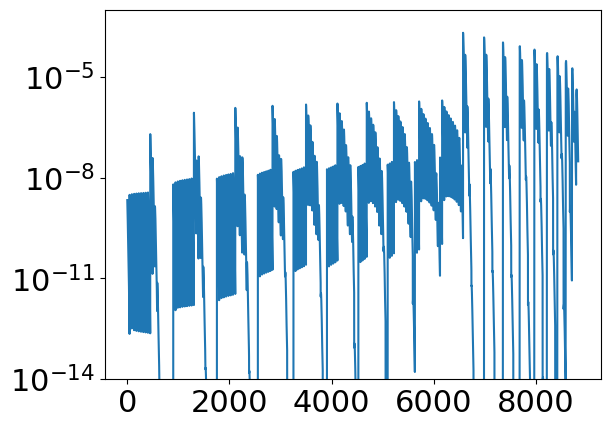

In [22]:
fig, ax = plt.subplots()
ax.semilogy(np.abs(means))
ax.set_ylim(1e-14,1e-3)

## Compute the covariance at the fiducial cosmology using ```jax-cosmo```

### Define the function

Again set the fiducial lens sample to MagLim and include all sources of systematics for lens and source galaxy samples, as above, for consistency.

In [23]:
def compute_gaussian_covariance(params,nzs_source,nzs_lens=nzs_l,ell=ell,f_sky=0.25, zpivot_ia=z0):
    """
    Rerturns the Gaussian covariance for a 3x2pt data vector
    """
    ## First unpack parameter vector
    cosmo_params, (A, eta), m, dz_s, b_l, dz_l = unpack_params_vec(params)
    #cosmo_params, (A, eta), m, dz_s= unpack_params_vec(params)  

    ## Define cosmology
    '''cosmo = jc.Cosmology(Omega_c=cosmo_params[0], 
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         sigma8=cosmo_params[3], 
                         n_s=cosmo_params[4],
                         w0=PL18_w0, wa=PL18_wa)#, gamma = cosmo_params[4])'''
    cosmo = jc.Cosmology(Omega_m=cosmo_params[1], 
                         Omega_b=cosmo_params[2],
                         Omega_k=cosmo_params[0],
                         h=cosmo_params[5],
                         S8=cosmo_params[7], 
                         n_s=cosmo_params[6],
                         w0=cosmo_params[3], wa=cosmo_params[4], gamma = cosmo_params[8])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    ## Define IA model
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)
    
    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l]

    ## Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=a_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l_sys, b)]
    
    cl_signal = jc.angular_cl.angular_cl(cosmo, ell, probes)
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=f_sky, sparse=False)
    cov = cov[matrix_inds_cut]
    print(cov.shape)
    
    return cov

### Call the function to get the covariance and compute its inverse

The inverse of the covariance matrix is usually referred to as the *precision matrix*.

In [24]:
cov_mat = compute_gaussian_covariance(fid_params,nzs_s, f_sky = 15000/41253)
prc_mat = np.linalg.inv(cov_mat)

(8830, 8830)


## Compute the Jacobian using jax-cosmo

We wrote a function to compute the mean of the 3x2-point data vector. We can use that to compute the Jacobian using ```jax-cosmo```

In [25]:
# Defining jax-cosmo jacobian
compute_3x2pt_jac = jax.jit(jax.jacfwd(compute_3x2pt_mean))

In [26]:
jacobian = compute_3x2pt_jac(fid_params,nzs_s)
#%timeit compute_3x2pt_jac(fid_params,nzs_s).block_until_ready()

## Compute Fisher matrix

Putting the mean and covariance together, we can now compute the Fisher matrix.
NOTE: This is, strictly speaking, only valid for Gaussian likelihoods. With ```jax-cosmo``` there is another way to compute the Fisher matrix wherein users manually define their likelihood. We will explore it below as a double-check.

In [27]:
## Take the matrix product
fisher = jacobian.T @ prc_mat @ jacobian
print(fisher.shape)

(51, 51)


In [28]:
print(fisher)

[[ 4.42394484e+06 -2.32580428e+07 -7.86524645e+06 ...  3.82014863e+05
  -4.19856228e+05 -3.24332526e+05]
 [-2.32580428e+07  1.35824635e+08  4.41674220e+07 ... -2.78005593e+06
   1.30905790e+06  1.01946483e+06]
 [-7.86524645e+06  4.41674220e+07  1.76637036e+07 ... -5.62669976e+05
   6.59757480e+05  4.09552031e+05]
 ...
 [ 3.82014863e+05 -2.78005593e+06 -5.62669976e+05 ...  3.35385513e+08
  -7.72570606e+07 -4.63225760e+05]
 [-4.19856228e+05  1.30905790e+06  6.59757480e+05 ... -7.72570606e+07
   9.63219497e+07 -8.39726743e+06]
 [-3.24332526e+05  1.01946483e+06  4.09552031e+05 ... -4.63225760e+05
  -8.39726743e+06  9.27045227e+06]]


```fisher``` is the full Fisher matrix. Below we can plot the whole matrix for a quick visual inspection. There should be no complain about any ```NaN``` of ```Inf``` when estimating the contours.

NOTE: This can take a while for a large Fisher matrix.

In [29]:
#Methods to easily save and load fisher matrices to storage
from numpy import savetxt, loadtxt

def saveFisher(fid_vals, fisher, fname='fisher.csv', delimiter=',', **kwargs):
   mat = np.append(fisher, np.reshape(fid_vals, (1, fisher.shape[0])), axis=0)
   savetxt(fname, mat, delimiter=delimiter, **kwargs)


def loadFisher(fname : str, delimiter=',', **kwargs):
   mat = loadtxt(fname, delimiter=delimiter, **kwargs)
   fisher = mat[:mat.shape[1], :mat.shape[1]]
   fid_vals = mat[mat.shape[1], :]
   return fid_vals, fisher

In [30]:
saveFisher(fid_params, fisher, fname='Results/Ext2-S8/Ext2-S8-Euclid-3x2.csv')

Text(0.5, 0.98, 'Euclid 3x2')

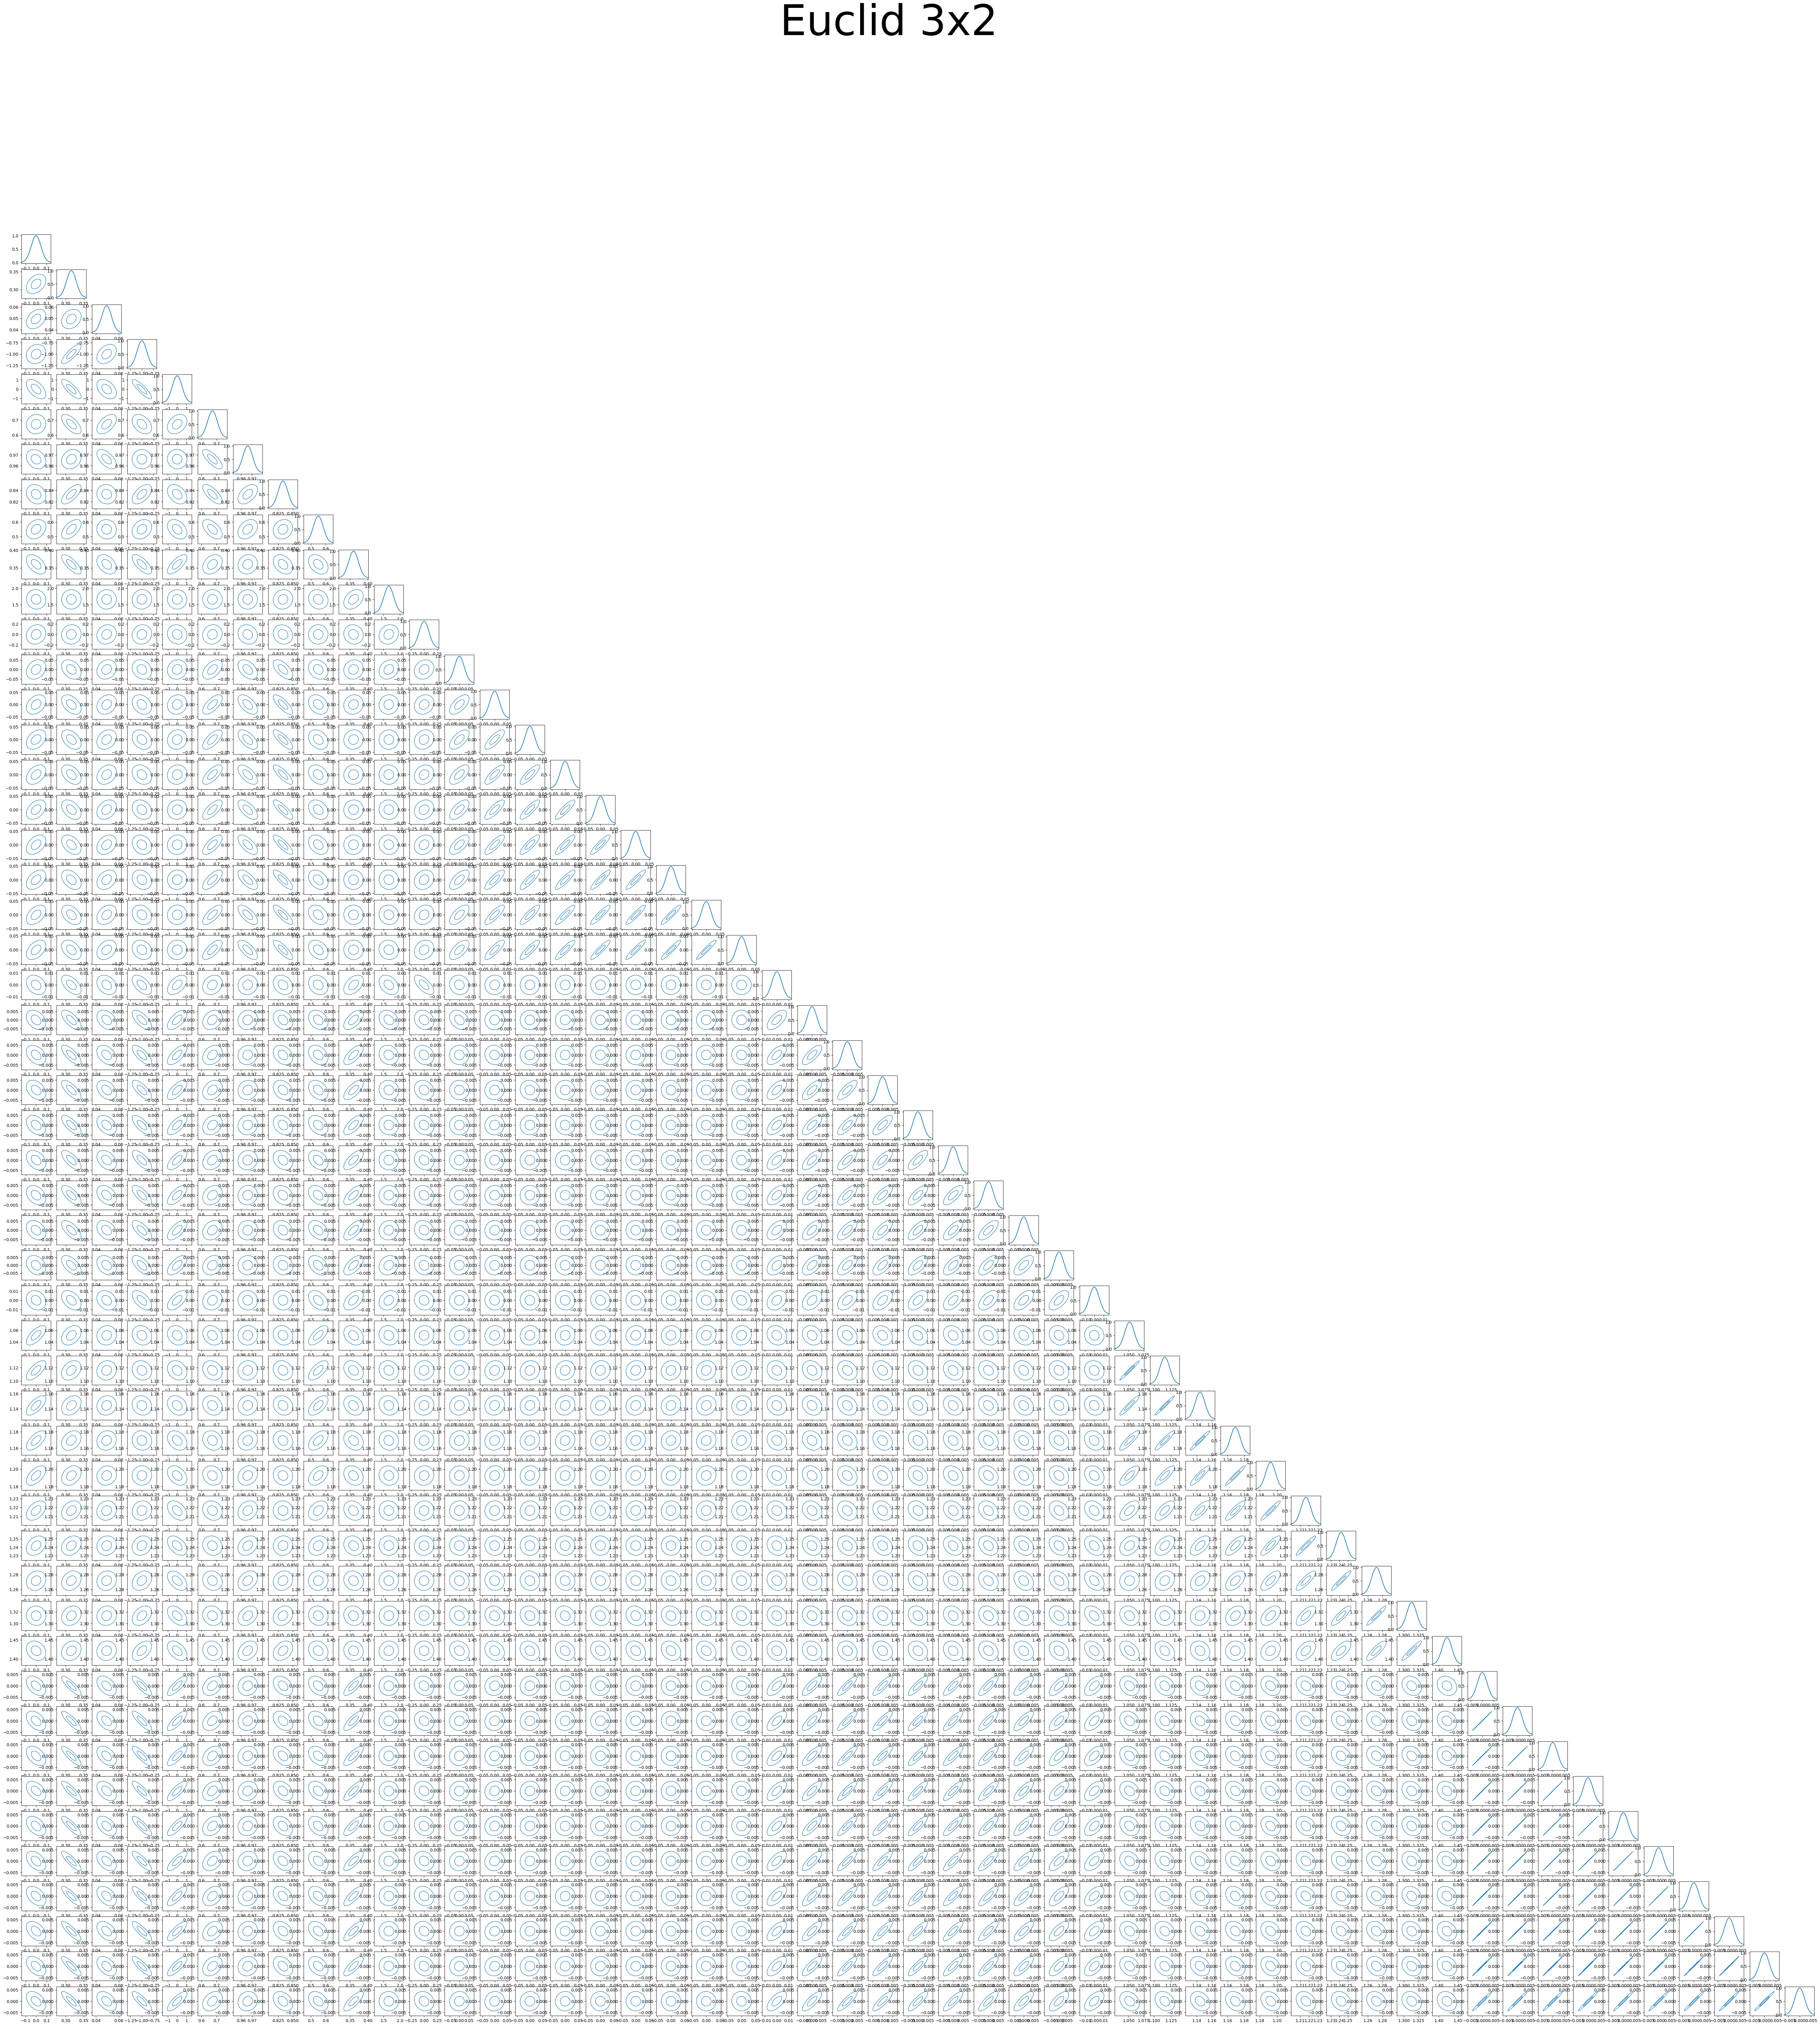

In [31]:
fig= plt.figure(figsize=(fisher.shape[0]*1.5, fisher.shape[1]*1.5))
plt.rcParams.update({
    "font.size": 10})

for i in range(fisher.shape[0]):
    for j in range(fisher.shape[1]):
        if j<i:
            plt.subplot(fisher.shape[0],fisher.shape[1],i*fisher.shape[0]+j+1)
            plot_contours(fisher, fid_params, np.array([j,i]),fill=False,color='C0')
        if j==i:
            plt.subplot(fisher.shape[0], fisher.shape[1], i*fisher.shape[0]+j+1)
            plot_Gaussian(fisher, fid_params, i, color='C0')
fig.suptitle('Euclid 3x2', fontsize=100)

Text(0.5, 0.98, 'Euclid 3x2')

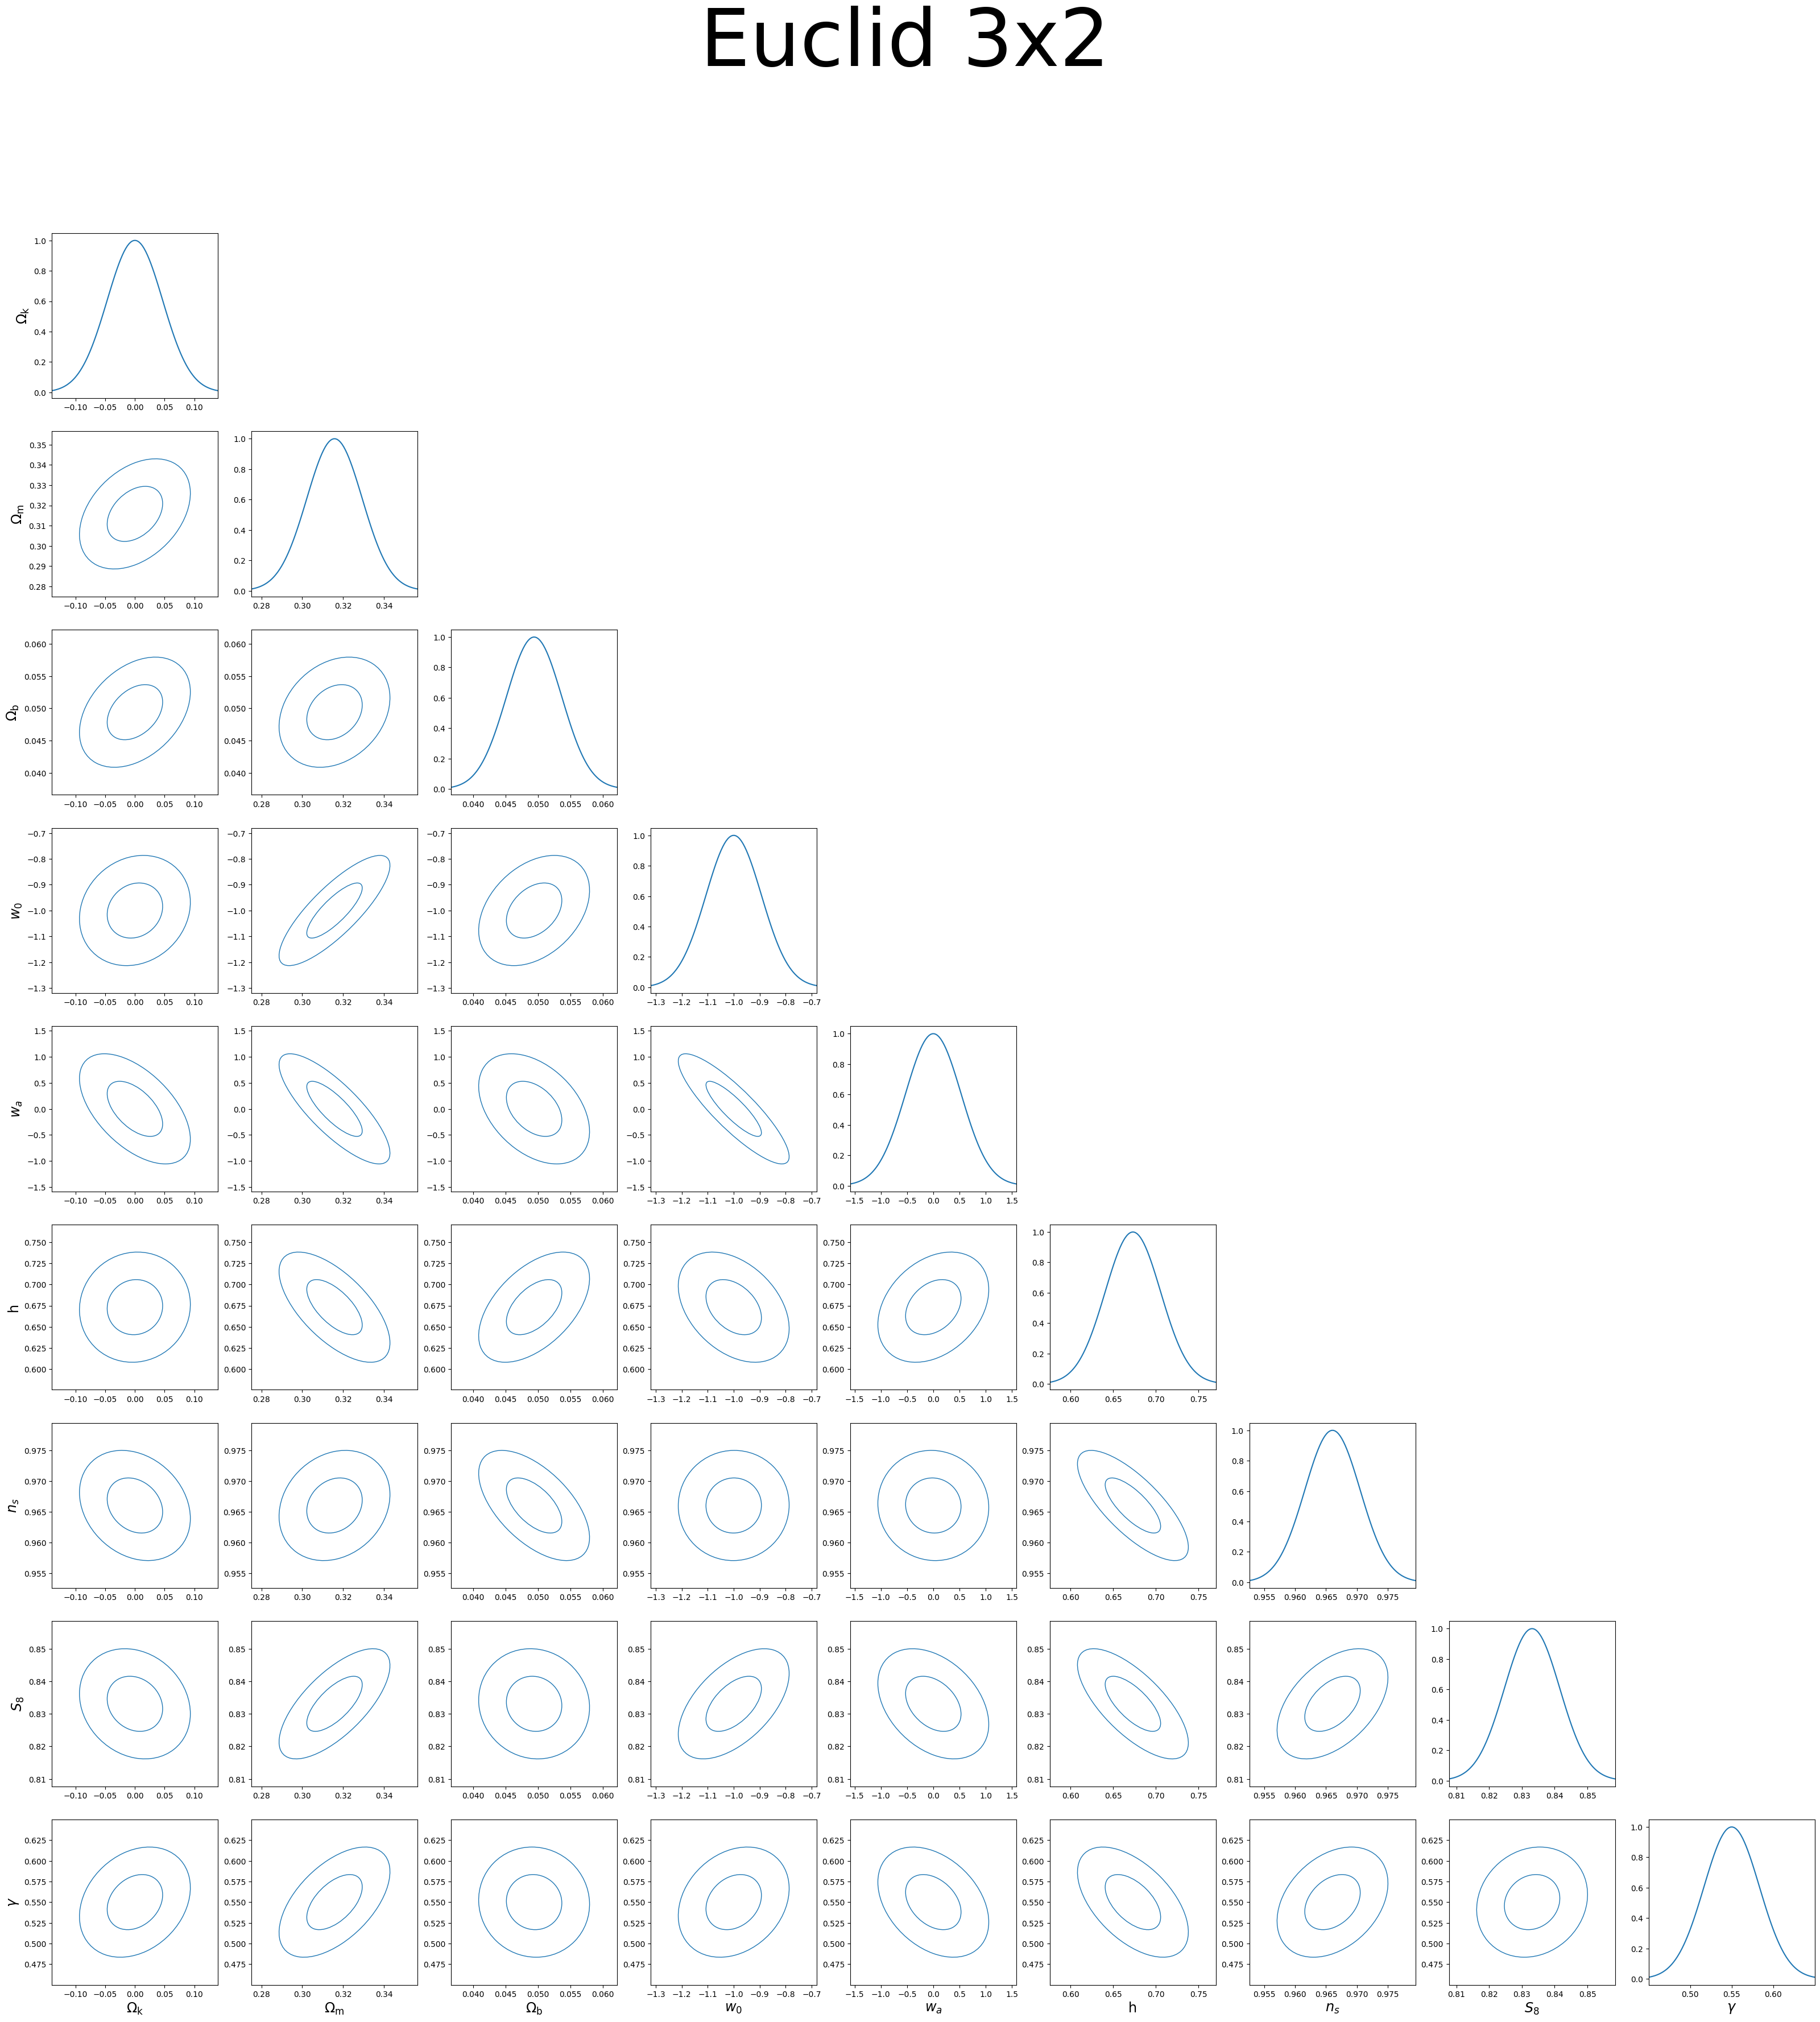

In [32]:
param_names = (r'$\Omega_\mathrm{k}$', r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$w_0$', r'$w_a$', 'h', r'$n_s$', r'$S_8$', r'$\gamma$')
F_cosmo_only = np.linalg.inv(np.linalg.inv(fisher)[:cosmo_param_nr, :cosmo_param_nr])
fid_params_subset = fid_params[:F_cosmo_only.shape[0]]

fig= plt.figure(figsize=((F_cosmo_only.shape[0]+1)*4, (F_cosmo_only.shape[1]+1)*4))
plt.rcParams.update({
    "font.size": 10})

axes = []

for i in range(F_cosmo_only.shape[0]):
    for j in range(F_cosmo_only.shape[1]):
        #print(str(i)+','+str(j))
        if j<i:
            ax = plt.subplot(F_cosmo_only.shape[0],F_cosmo_only.shape[1],i*F_cosmo_only.shape[0]+j+1)
            if j==0 or i==F_cosmo_only.shape[0]-1:
                axes.append(ax)
            plot_contours(F_cosmo_only, fid_params_subset, np.array([j,i]), ax=ax, fill=False,color='C0')
        if j==i:
            ax = plt.subplot(F_cosmo_only.shape[0],F_cosmo_only.shape[1],i*F_cosmo_only.shape[0]+j+1)
            if j==(cosmo_param_nr-1) or j==0:
                axes.append(ax)
            plot_Gaussian(F_cosmo_only, fid_params, i, ax=ax, color='C0')
for i in np.arange(cosmo_param_nr):
    axes[i].set_ylabel(param_names[i], fontsize='xx-large')
    axes[i+cosmo_param_nr-1].set_xlabel(param_names[i], fontsize='xx-large')

fig.suptitle('Euclid 3x2', fontsize=100)

## Compute Fisher matrix -- Alternative Method #2, using finite differencing and the [DESC Core Cosmology Library](https://github.com/LSSTDESC/CCL) ```CCL```

In [33]:
raise Exception('Stop!')

Exception: Stop!

To gain more confidence on the Fisher evaluation and inversion by ```jax-cosmo``` and the ```autodiff``` approach, we can cross-check results with the same outputs from the finite differencing approach using ```CCL```.

NOTE: Use a very fine sampling grid in finite differencing to ensure accuracy.

### Specify standard input parameter(s) for the function

In [ ]:
zsamp = np.linspace(0.,4.,2048)
cosmo_params = [PL18_omegacdm,PL18_omegab,PL18_h,PL18_sigma8,PL18_ns]
stepsize = .004

### Define utility function(s) to use with CCL

In [ ]:
# Define IA bias for DES Y1
def des_y1_ia_bias(z, A, eta, z0=0.62):
    """
    https://arxiv.org/pdf/1708.01538.pdf Sec. VII.B
    Parameters:
    -----------
    A: amplitude
    eta: redshift dependent slope
    z0: pivot redshift
    """
    return A * ((1.0 + z) / (1.0 + z0)) ** eta

### Define the function to compute the mean of the 3x2-point data vector

This is exactly the same function as above, only built with ```CCL``` and finite-differencing instead of ```jax-cosmo``` and ```autodiff```.

In [ ]:
def ccl_3x2pt_mean(params,nzs_source,nzs_lens=nzs_l,ell=ell,zpivot_ia=z0,f_sky=0.25):
    """
    Returns the mean data vector provided a set of
    cosmological and nuisance parameters, using CCL
    """
    cosmo_params, (A, eta), m, dz_s, b_l, dz_l = unpack_params_vec(params)
    ## We define the cosmology
    ## here we need to explicitly convert the ArrayImpl elements into float as CCL enforces type ```double``` for these parameters
    cosmo_ccl = ccl.Cosmology(
        Omega_c=float(cosmo_params[0]), Omega_b=float(cosmo_params[1]),
        h=float(cosmo_params[2]), 
        sigma8=float(cosmo_params[3]),
        n_s=float(cosmo_params[4]),
        #w0=PL18_w0, wa=PL18_wa,
        #Neff=0.,
        transfer_function='eisenstein_hu', 
        matter_power_spectrum='halofit')
    
    # Build source nz with redshift systematic bias
    # Uses same function as jax-cosmo to ensure consistency
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz_s)]
    
    # We build the tracers for each redshift bins
    tracers = [ccl.WeakLensingTracer(cosmo_ccl, (zsamp, nzs_s_sys[i](zsamp)),
                                     ia_bias=(zsamp, des_y1_ia_bias(zsamp, A, eta))) for i in range(len(nzs_source))]
    # And we keep track of a term for multiplicative biases, for shear only
    m_biases = [1.+m[i] for i in range(10)]
    m_biases += [1. for i in range(10)]

    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    tracers += [ccl.NumberCountsTracer(cosmo_ccl,
                                       has_rsd=False,
                                       dndz=(zsamp, nzs_l_sys[i](zsamp)),
                                       bias=(zsamp, b_l[i]*np.ones_like(zsamp))) for i in range(len(nzs_lens))]
    n_tracers = len(tracers)
    
    # Compute all cross correlations
    cls = []
    for i in range(n_tracers):
        for j in range(i, n_tracers):
            cls.append(ccl.angular_cl(cosmo_ccl, tracers[i], tracers[j], ell)*m_biases[i]*m_biases[j])

    return np.concatenate(cls)

### Call the function to compute the mean prediction at the *same* set of fiducial parameters used above

In [ ]:
ccl_means = ccl_3x2pt_mean(fid_params,nzs_s)

### Compare the mean predictions between ```CCL``` and ```jax-cosmo```

#### All range, absolute value

In [ ]:
fig,ax=plt.subplots()
ax.semilogy(abs(means),ls='-',color='C0',label='jax-cosmo')
ax.semilogy(abs(ccl_means),ls='--',color='C1',label='CCL')
ax.set_ylim(1e-14,1e-3)
ax.legend(frameon=False)

#### High multipoles

In [ ]:
fig,ax=plt.subplots()
ax.semilogy(means[50*30:],ls='-',color='C0',label=r'jax-cosmo')
ax.semilogy(ccl_means[50*30:],ls='--',color='C1',label=r'CCL')
ax.legend(frameon=False)

### Compute the Jacobian and Fisher matrices by finite differencing

#### Define the Jacobian

In [ ]:
import numdifftools as nd
# Defining CCL jacobian
ccl_3x2pt_jac = nd.Jacobian(ccl_3x2pt_mean, step=stepsize)

#### Compute Jacobian at fiducial parameter values

In [ ]:
ccl_jacobian = ccl_3x2pt_jac(fid_params,nzs_s)

#### Visualization and comparison between ```CCL``` and ```jax-cosmo``` Jacobians

In [ ]:
fig,ax=plt.subplots()
ax.semilogy(abs(jacobian[:,0]),ls='-',color='C0',label=r'jax-cosmo')
ax.semilogy(abs(ccl_jacobian[:,0]),ls='--',color='C1',label=r'CCL')
ax.legend(frameon=False)

#### Compute the Fisher matrix

We reuse the precision matrix computed earlier using ```jax-cosmo```

In [ ]:
ccl_fisher = ccl_jacobian.T @ prc_mat @ ccl_jacobian
print(ccl_fisher.shape)

In [ ]:
print(ccl_fisher)

### Compare the Fisher matrices from ```CCL``` and ```jax-cosmo```

In [ ]:
fig= plt.figure(figsize=(fisher.shape[0]*2, fisher.shape[1]*2))
plt.rcParams.update({
    "font.size": 10})

ellip_jax = None
ellip_cll = None
for i in range(fisher.shape[0]):
    for j in range(fisher.shape[1]):
        if j<i:
            if j==0 and i==1:
                plt.subplot(fisher.shape[0],fisher.shape[1],i*fisher.shape[0]+j+1)
                ellip_jax = plot_contours(fisher, fid_params, np.array([j,i]),fill=False,ls='-',color='C0', label='Jax')
                ellip_ccl = plot_contours(ccl_fisher, fid_params, np.array([j,i]),fill=False,ls='--',color='C1', label='CCL')
            else:
                plt.subplot(fisher.shape[0],fisher.shape[1],i*fisher.shape[0]+j+1)
                plot_contours(fisher, fid_params, np.array([j,i]),fill=False,ls='-',color='C0')
                plot_contours(ccl_fisher, fid_params, np.array([j,i]),fill=False,ls='--',color='C1')
        if j==i:
            plt.subplot(fisher.shape[0],fisher.shape[1],i*fisher.shape[0]+j+1)
            plot_Gaussian(fisher, fid_params, i,ls='-',color='C0')
            plot_Gaussian(ccl_fisher, fid_params, i,ls='--',color='C1')
fig.suptitle('CCL vs. Jax, CCL step = '+str(stepsize), fontsize=100)
fig.legend([ellip_jax[0], ellip_ccl[0]], ['Jax', 'CCL'], loc='center right', fontsize=100)
filename = str(stepsize)+'.png'
fig.savefig(filename)

In [ ]:
param_names = (r'$\Omega_c$', r'$\Omega_b$', 'h', r'$\sigma_8$', r'$n_s$')
F_cosmo_only_ccl = np.linalg.inv(np.linalg.inv(ccl_fisher)[:cosmo_param_nr, :cosmo_param_nr])
F_cosmo_only_jax = np.linalg.inv(np.linalg.inv(fisher)[:cosmo_param_nr, :cosmo_param_nr])

fig= plt.figure(figsize=((F_cosmo_only_ccl.shape[0]+1)*4, (F_cosmo_only_ccl.shape[1]+1)*4))
plt.rcParams.update({
    "font.size": 10})

axes = []

for i in range(F_cosmo_only_ccl.shape[0]):
    for j in range(F_cosmo_only_ccl.shape[1]):
        #print(str(i)+','+str(j))
        if j<i:
            ax = plt.subplot(F_cosmo_only_ccl.shape[0],F_cosmo_only_ccl.shape[1],i*F_cosmo_only_ccl.shape[0]+j+1)
            if j==0 or i==F_cosmo_only_ccl.shape[0]-1:
                axes.append(ax)
            plot_contours(F_cosmo_only_jax, fid_params_subset, np.array([j,i]), ax=ax, fill=False,color='C0')
            plot_contours(F_cosmo_only_ccl, fid_params_subset, np.array([j,i]), ax=ax, fill=False,color='C1', ls='--')
        if j==i:
            ax = plt.subplot(F_cosmo_only.shape[0],F_cosmo_only.shape[1],i*F_cosmo_only.shape[0]+j+1)
            if j==(cosmo_param_nr-1) or j==0:
                axes.append(ax)
            plot_Gaussian(F_cosmo_only_jax, fid_params, i, ax=ax, color='C0')
            plot_Gaussian(F_cosmo_only_ccl, fid_params, i, ax=ax, color='C1', ls='--')

for i in np.arange(F_cosmo_only_ccl.shape[0]):
    axes[i].set_ylabel(param_names[i], fontsize='xx-large')
    axes[i+cosmo_param_nr-1].set_xlabel(param_names[i], fontsize='xx-large')

fig.suptitle('Euc 3x2 CCL vs Jax, step = '+str(stepsize), fontsize=75)
fig.legend()